## Trend Example 1

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import ffn
import bt

%matplotlib inline

### Create fake data

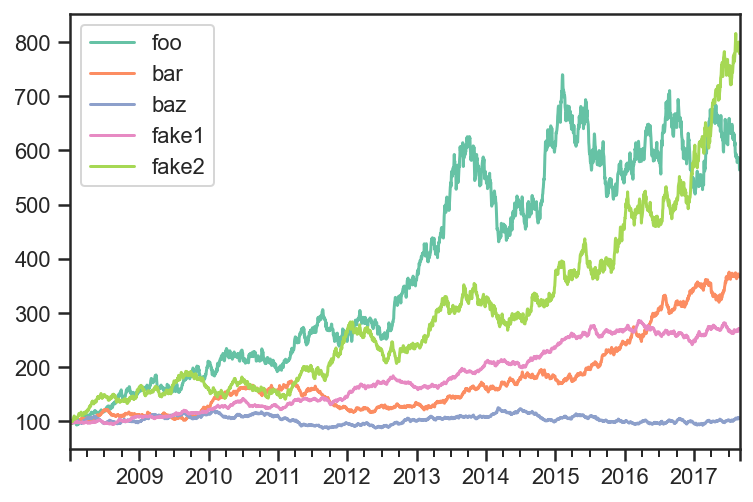

In [3]:
rf = 0.04
np.random.seed(1)
mus = np.random.normal(loc=0.05,scale=0.02,size=5) + rf
sigmas = (mus - rf)/0.3 + np.random.normal(loc=0.,scale=0.01,size=5)

num_years = 10
num_months_per_year = 12
num_days_per_month = 21
num_days_per_year = num_months_per_year*num_days_per_month

rdf = pd.DataFrame(
    index = pd.date_range(
        start="2008-01-02",
        periods=num_years*num_months_per_year*num_days_per_month,
        freq="B"
    ),
    columns=['foo','bar','baz','fake1','fake2']
)

for i,mu in enumerate(mus):
    sigma = sigmas[i]
    rdf.iloc[:,i] = np.random.normal(
        loc=mu/num_days_per_year,
        scale=sigma/np.sqrt(num_days_per_year),
        size=rdf.shape[0]
    )
pdf = np.cumprod(1+rdf)*100

pdf.plot();

### Create Trend signal over the last 12 months

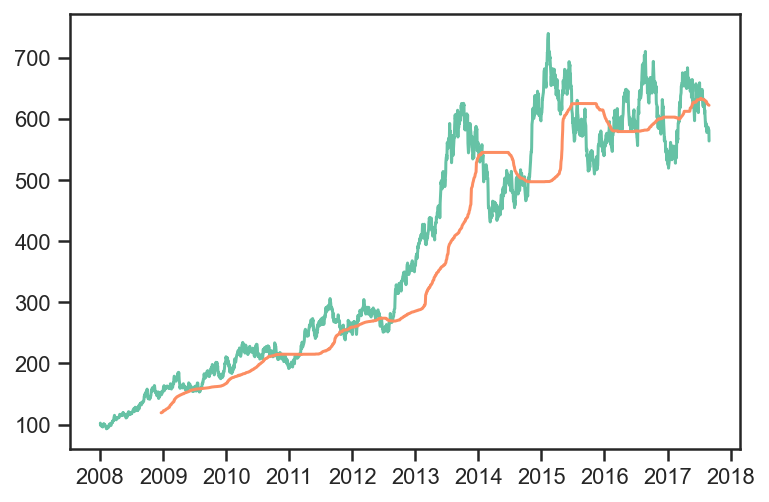

In [4]:
sma  = pdf.rolling(window=num_days_per_month*12,center=False).median().shift(1)
plt.plot(pdf.index,pdf['foo'])
plt.plot(sma.index,sma['foo'])
plt.show()

In [5]:
#sma with 1 day lag
sma.tail()

,foo,bar,baz,fake1,fake2
2017-08-23,623.241267,340.774506,99.764885,263.491447,619.963986
2017-08-24,623.167989,341.096742,99.764885,263.502145,620.979948
2017-08-25,622.749149,341.316672,99.764885,263.502145,622.421401
2017-08-28,622.353039,341.494307,99.807732,263.517071,622.962579
2017-08-29,622.153294,341.662442,99.807732,263.517071,622.992416


In [6]:
#sma with 0 day lag
pdf.rolling(window=num_days_per_month*12,center=False).median().tail()

,foo,bar,baz,fake1,fake2
2017-08-23,623.167989,341.096742,99.764885,263.502145,620.979948
2017-08-24,622.749149,341.316672,99.764885,263.502145,622.421401
2017-08-25,622.353039,341.494307,99.807732,263.517071,622.962579
2017-08-28,622.153294,341.662442,99.807732,263.517071,622.992416
2017-08-29,621.907867,341.948212,99.807732,263.634283,624.310473


In [7]:
# target weights
trend = sma.copy()
trend[pdf > sma] = True
trend[pdf <= sma] = False
trend[sma.isnull()] = False
trend.tail()

,foo,bar,baz,fake1,fake2
2017-08-23,False,True,True,True,True
2017-08-24,False,True,True,True,True
2017-08-25,False,True,True,True,True
2017-08-28,False,True,True,True,True
2017-08-29,False,True,True,True,True


Compare EW and 1/vol

Both strategies rebalance daily using trend with 1 day lag and weights limited to 40%.

In [8]:


tsmom_invvol_strat = bt.Strategy(
    'tsmom_invvol',
    [
        bt.algos.RunDaily(),
        bt.algos.SelectWhere(trend),
        bt.algos.WeighInvVol(),
        bt.algos.LimitWeights(limit=0.4),
        bt.algos.Rebalance()
    ]
)

tsmom_ew_strat = bt.Strategy(
    'tsmom_ew',
    [
        bt.algos.RunDaily(),
        bt.algos.SelectWhere(trend),
        bt.algos.WeighEqually(),
        bt.algos.LimitWeights(limit=0.4),
        bt.algos.Rebalance()
    ]
)

In [9]:
# create and run
tsmom_invvol_bt = bt.Backtest(
    tsmom_invvol_strat,
    pdf,
    initial_capital=50000000.0,
    commissions=lambda q, p: max(100, abs(q) * 0.0021),
    integer_positions=False,
    progress_bar=True
)
tsmom_invvol_res = bt.run(tsmom_invvol_bt)

tsmom_ew_bt = bt.Backtest(
    tsmom_ew_strat,
    pdf,
    
    initial_capital=50000000.0,
    commissions=lambda q, p: max(100, abs(q) * 0.0021),
    integer_positions=False,
    progress_bar=True
)
tsmom_ew_res = bt.run(tsmom_ew_bt)

tsmom_invvol
0% [############################# ] 100% | ETA: 00:00:00tsmom_ew
0% [############################# ] 100% | ETA: 00:00:00

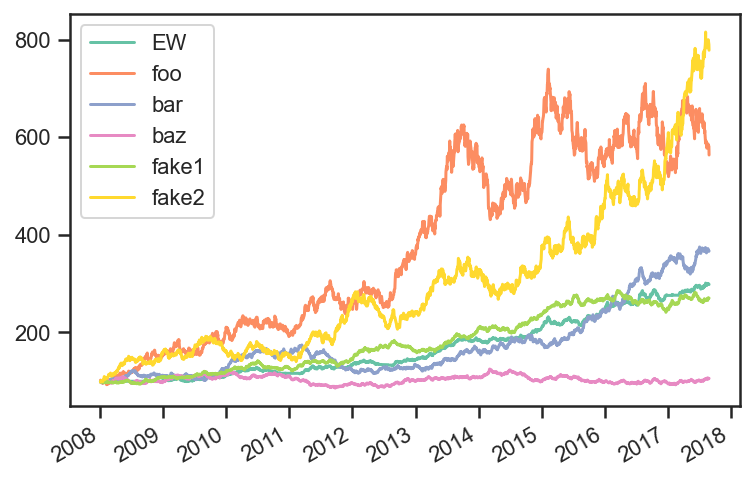

In [10]:
ax = plt.subplot()
ax.plot(tsmom_ew_res.prices.index,tsmom_ew_res.prices,label='EW')
pdf.plot(ax=ax)

ax.legend()
plt.legend()
plt.show()


In [11]:
tsmom_ew_res.stats

,tsmom_ew
start,2008-01-01 00:00:00
end,2017-08-29 00:00:00
rf,0.0
total_return,1.982933
cagr,0.119797
max_drawdown,-0.103421
calmar,1.158343
mtd,0.017544
three_month,0.040722
six_month,0.079362
